In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!cp '/gdrive/My Drive/Final Project/images.zip' .
!cp '/gdrive/My Drive/Final Project/MoreImages.zip' .
!cp '/gdrive/My Drive/Final Project/annotations/captions.json' .
!cp '/gdrive/My Drive/Final Project/annotations/labels.json' .
!cp '/gdrive/My Drive/Final Project/annotations/images_info.json' .
!cp '/gdrive/My Drive/Final Project/annotations/categories_info.json' .
!unzip -q images.zip
!unzip -q MoreImages.zip
!mv -v val2017/* MoreImages/
!mv MoreImages images
!rm -r val2017
!rm -r __MACOSX
!rm images.zip
!rm MoreImages.zip

unzip:  cannot find or open images.zip, images.zip.zip or images.zip.ZIP.
unzip:  cannot find or open MoreImages.zip, MoreImages.zip.zip or MoreImages.zip.ZIP.
mv: cannot stat 'val2017/*': No such file or directory
mv: cannot stat 'MoreImages': No such file or directory
rm: cannot remove 'val2017': No such file or directory
rm: cannot remove '__MACOSX': No such file or directory
rm: cannot remove 'images.zip': No such file or directory
rm: cannot remove 'MoreImages.zip': No such file or directory


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Image Captioning
In this part of the project, the image captioning task is done. Image captionaning task is to give a text describtion of the input image. Two different networks are needed to perform this task. the first network to extract features (like the network used in the last part of the project) and a network to generate captions (usually a rnn network).

An `inception_resnet_v2` network is used for feature extraction, and a bidirectional GRU is used for caption generating. Attention mechanisim is added to this model. 

Last layer of inception network is 8 * 8 * 1536 images which by flatting it gives, 64 * 1536 vectors. The idea used here is a novel modified version of the same idea as https://arxiv.org/abs/1703.09137 to generate captions. In this project, image features and the output of the bidirectional GRU is added together and the output goes through a dense and then a softmax output layer with the size of number of words in vocabulary. Our modification is to add attention model to this network. instead of using only the last state of the bidirectional GRU, We use attention model using 64 * 1536 features extracted from our network. This reults in generating the new word regarding all the words generated so far, using image features. By doing this, the result becomes much better.

An Adam optimizer with 0.00001 learning rate is chosen. Loss is set to categorical entropy.

In abstract, ideas used throughout this part of project is:

* A novel model by adding attention mechanism to the bidirectional GRU
* Model adding method in Image Captioning
* Partial captioning
* Dropout
* Early stopping
* He initializer


## Preprocessing
libraries are imported

In [0]:
# Basic libraries

import numpy as np
import cv2
import json
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# Keras basic libraries
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import GRU, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling2D, GlobalAveragePooling1D, Input, add, Reshape, TimeDistributed, Bidirectional, Dot, Concatenate, Activation
from keras.optimizers import SGD, Adam
from keras import Model
from keras.models import load_model

# Pre-trained CNN networks
from keras.applications.vgg19 import VGG19
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import inception_resnet_v2

Parameters are defined here.

In [0]:
# Defining parameters

MAX_NUM_CLASS = 90
BATCH_SIZE = 1024
EPOCH_SIZE = 50
INPUT_WIDTH = 299
INPUT_HEIGHT = 299
INPUT_SIZE = ( INPUT_WIDTH, INPUT_HEIGHT )
INPUT_SHAPE = ( INPUT_WIDTH, INPUT_HEIGHT, 3 )

Function is defined in this section.
* json2dict: Extract dictionary from read JSON file


In [0]:
# Function to convert json file into a dictionary

def json2dict( json_file, id_str, category_id, category_2_id = ' ', category_3_id = ' '):
    dict_ = dict()
    for label in json_file:
        if ( label[ id_str ] not in dict_.keys() ):
            dict_[ label[ id_str ] ] = []
        if( label[ category_id ] not in dict_[ label[ id_str ] ] ):
            dict_[ label[ id_str ] ].append( label[ category_id ] )  # Append dictionary enteries
            dict_[ label[ id_str ] ] = list( np.sort( dict_[ label[ id_str ] ] ) )   # Sort dictionary entries
        if( not( category_2_id == ' ' ) ):
            dict_[ label[ id_str ] ].append( label[ category_2_id ] )
        if( not( category_3_id == ' ' ) ):
            dict_[ label[ id_str ] ].append( label[ category_3_id ] )
    return dict_

Dictionaries are constructed in this part.

In [0]:
with open('captions.json', 'r') as path:
    json_captions = json.load( path )
with open('images_info.json', 'r') as path:
    json_image_info = json.load( path )

In [7]:
# Crafting dictionaries from data

dict_captions = json2dict( json_captions, 'image_id', 'caption' )
dict_image_info = json2dict( json_image_info, 'id', 'file_name' )

print( 'Captions dictionary length: {0}'.format( len( dict_captions ) ) )
print( 'Image info dictionary length: {0}'.format( len( dict_image_info ) ) )
print( '\nCaptions dictionary: format [image_ID]:[labels]')
print( dict(list(dict_captions.items())[0:2]) )
print( '\nImage info dictionary: format [image_ID]:[file_name]')
print( dict(list(dict_image_info.items())[0:3]) )

Captions dictionary length: 15000
Image info dictionary length: 15000

Captions dictionary: format [image_ID]:[labels]
{179765: ['A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle parked in front of a garage.', 'A black Honda motorcycle with a dark burgundy seat.', 'A motorcycle with its brake extended standing outside', 'Ma motorcycle parked on the gravel in front of a garage'], 190236: ['A desk and chair in an office cubicle.', 'An office cubicle with four different types of computers.', 'Office setting with a lot of computer screens.', 'The home office space seems to be very cluttered.', 'an office with desk computer and chair and laptop.']}

Image info dictionary: format [image_ID]:[file_name]
{397133: ['000000397133.jpg'], 37777: ['000000037777.jpg'], 252219: ['000000252219.jpg']}


Constructing image dictionary. given id, it gives the image.

In [0]:
image_dict = dict()
for image_id in dict_image_info:
    image_dict[ image_id ] = ( cv2.resize( cv2.imread( './images/' + dict_image_info[ image_id ][0] ),  INPUT_SIZE ) )

In this part the model is defined. `inception_resnet_v2` is used as the base model without the classifier layers.

In [8]:
# Declaring the base model
model_feature_extractor = InceptionResNetV2( include_top=False, weights='imagenet', input_shape=INPUT_SHAPE )
reshape = Reshape((64, 1536))( model_feature_extractor.layers[-1].output )
model_fe = Model( model_feature_extractor.inputs, reshape )














219062272/219055592 [==============================] - 5s 0us/step


### Caption preprocess
Captions are first read to the `caption_list`. Then this list is filtered and preprocessed using `Tokenizer`. Finally, partional captioning idea is done. In partial captioning, each data point becomes image and only a partial of caption. for example, if our image_1's caption is "a white cat sitting on a couch", our data points become:

* image_1 -> "a"
* image_1 -> "a white"
* $ \vdots $
* image_1 -> "a white cat sitting on a couch"

Then these data points are converted to sequences of index values, assigning each word an index. at the end padding is done through `pad_sequence`. for captions, `<start>`, `<end>`, and `<pad>` are used to start, end, and padding words.

In [0]:
# Prepeocess data
caption_list = []
X_temp = []
for image_id in dict_captions:
  X_temp_ = model_fe.predict( inception_resnet_v2.preprocess_input( np.expand_dims( image_dict[ image_id ], axis=0 ) ) )
  for caption in dict_captions[ image_id ]:
    caption = '<start> ' + caption + ' <end>'
    caption_list.append( caption )
    X_temp.append( X_temp_ )

In [0]:
tokenizer = Tokenizer(num_words=None, oov_token="<unk>", filters='!"#$%&()*+.,/:;=?@[\]^_`{|}~ ', lower=True )
tokenizer.fit_on_texts(caption_list)
caption_list = tokenizer.sequences_to_texts( tokenizer.texts_to_sequences( caption_list ) ) 

In [0]:
import pickle
with open('/gdrive/My Drive/Final Project/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [0]:
X = []
input_seq = []
Y = []
for index, caption in enumerate(caption_list):
  caption_sp = caption.split(' ')
  for i in range( len( caption_sp ) - 1 ):
    input_seq.append( ' '.join( caption_sp[:(i + 1)] ) )
    X.append( X_temp[ index ] )
    Y.append( caption_sp[ i + 1 ] )

In [0]:
input_seq_coded = tokenizer.texts_to_sequences( input_seq )
Y_seq_coded = tokenizer.texts_to_sequences( Y )
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
input_seq_coded_padded = pad_sequences(input_seq_coded, padding='post')
Y_seq_coded = np.reshape(Y_seq_coded, (len(Y_seq_coded)))

In [0]:
MAX_SEQ_LEN = len( input_seq_coded_padded[0] )
EMBED_DIM = 200
VOCAB_SIZE = len( tokenizer.index_word )

### Word2Vec Glove
Loading weights of embedding layer from Glove200d.

In [0]:
# Load Glove vectors
embeddings_index = {}
f = open('glove.6B.' + str(EMBED_DIM) + 'd.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros( (VOCAB_SIZE, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Defining structure of the model
In this section the model is defined. The model structure is described before.

### Encoding
Input layer is the feature extracted from `inception_resnet_v2`. average pooling and dropout is applied and then `fe_output` is calculated to add to the output of bidirectional GRU after attention. `image_features` is to feed to attention model in the next part.

In [0]:
units = 512

input_fe = Input( (64, 1536,) )
average_pooling = GlobalAveragePooling1D()(input_fe)
fe1 = Dropout(0.5)(average_pooling)
fe_output = Dense(units, activation='relu')(fe1)

dense_1_h = Dense(units, activation='relu')(input_fe)
dense_1_c = Dense(units, activation='relu')(input_fe)

image_features = TimeDistributed(Dense(1536, activation="relu"))(input_fe)

### RNN Model
Input is the padded caption and after Word2Vec transformation, it is fed to Bidirectional GRU. Instead of passing the last hidden layer to add to the `fe_output`, we calculate the attention using the `image_features`.

In [0]:
input_lstm = Input(shape=(MAX_SEQ_LEN,))
se1 = Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, name='embedding_layer')(input_lstm)
se2 = Dropout(0.5)(se1)
se_out = Bidirectional(GRU(768, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([se_out, image_features])
attention = Activation('softmax')(attention)

context = Dot(axes=[2, 1])([attention, image_features])
decoder_context = Concatenate(axis=-1)([context, se_out])

se_output = TimeDistributed(Dense(units, activation='tanh'))(decoder_context)
se_output = GlobalAveragePooling1D()(se_output)

### Decoder
Output of last two parts are added together and then given to a dense layer and output is a softmax of a vocab size is the output size.

In [0]:
# decoder model
decoder1 = add([fe_output, se_output])
decoder2 = Dense(512, activation='relu')(decoder1)
output = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

model = Model( inputs=[input_fe, input_lstm], outputs=output )

Embedding layer's weight is set to the calculated from GloveModel and it is freezed.

In [0]:
model.get_layer('embedding_layer').set_weights([embedding_matrix])
model.get_layer('embedding_layer').trainable = False

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001))

In [0]:
def data_generator( X, input_seq, Y, vocab_size, batch_size):
  input1 = []
  input2 = []
  output = []
  n = 0
  while True:
    for i in range( len(X) ):
      n += 1
      input1.append( np.reshape( X[i], (64,1536) ) )
      input2.append( input_seq[i] )
      output.append( to_categorical( Y[i], vocab_size) )
      
      if( n == batch_size ):
        yield [[np.array(input1), np.array(input2)], np.array(output)]
        input1 = []
        input2 = []
        output = []
        n = 0

In [0]:
history = model.fit_generator( data_generator( X, input_seq_coded_padded, Y_seq_coded, VOCAB_SIZE, BATCH_SIZE ), steps_per_epoch=len(X)/BATCH_SIZE, epochs=10 )

Epoch 1/10
839/838 [==============================] - 552s 658ms/step - loss: 2.1334
Epoch 2/10
839/838 [==============================] - 552s 657ms/step - loss: 2.0998
Epoch 3/10
839/838 [==============================] - 552s 657ms/step - loss: 2.0665
Epoch 4/10
839/838 [==============================] - 552s 657ms/step - loss: 2.0364
Epoch 5/10
839/838 [==============================] - 551s 657ms/step - loss: 2.0051
Epoch 6/10
839/838 [==============================] - 551s 657ms/step - loss: 1.9756
Epoch 7/10
839/838 [==============================] - 551s 657ms/step - loss: 1.9465
Epoch 8/10
839/838 [==============================] - 551s 657ms/step - loss: 1.9202
Epoch 9/10
839/838 [==============================] - 552s 657ms/step - loss: 1.8959
Epoch 10/10
839/838 [==============================] - 552s 658ms/step - loss: 1.8725


In [0]:
model.save('/gdrive/My Drive/Final Project/model_attention_15k_imagecap.h5')

## Inference Model
Two major inference model is used. Greedy search and Beam search. Greedy search is when you pick the next word with the most probablity. Beam search is when you store K-best next words and in the end choose the best result. 

In [0]:
MAX_SEQ_LEN = 50
INPUT_WIDTH = 299
INPUT_HEIGHT = 299
INPUT_SHAPE = ( INPUT_WIDTH, INPUT_HEIGHT, 3 )

model = load_model('/gdrive/My Drive/Final Project/model_attention_15k_imagecap.h5')
with open('/gdrive/My Drive/Final Project/tokenizer.pkl', 'rb') as f:
  tokenizer = pickle.load(f)

In [0]:
model_feature_extractor = InceptionResNetV2( include_top=False, weights='imagenet', input_shape=INPUT_SHAPE )
reshape = Reshape((64, 1536))( model_feature_extractor.layers[-1].output )
model_fe = Model( model_feature_extractor.inputs, reshape )

In [0]:
def greedySearch(photo):
    in_text = '<start>'
    for i in range(MAX_SEQ_LEN):
        sequence = [tokenizer.word_index[w] for w in in_text.split() if w in tokenizer.word_index]
        sequence = pad_sequences([sequence], maxlen=MAX_SEQ_LEN)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
def beam_search_predictions(image, beam_index = 3):
    in_text = [tokenizer.word_index['<start>']]
    
    start_word = [[in_text, 0.0]]
    
    while len(start_word[0][0]) < MAX_SEQ_LEN:
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=MAX_SEQ_LEN, padding='post')
            preds = model.predict([image, sequence], verbose=0)
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp

        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

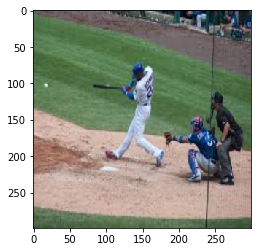

    Greedy Search: a baseball player is swinging a bat at a baseball game
Beam Search (K=3): a baseball player holding a bat at a baseball game
Beam Search (K=5): a baseball player holding a bat at a baseball game
Beam Search (K=7): a baseball player holding a bat at a baseball game


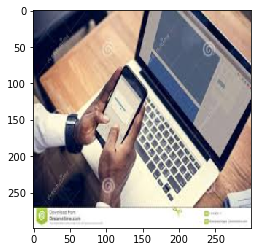

    Greedy Search: a man is holding a laptop and a person on the ground
Beam Search (K=3): a man holding a laptop and a person on a bench
Beam Search (K=5): a man holding a cell phone next to a laptop
Beam Search (K=7): there is a person that is next to a cell phone


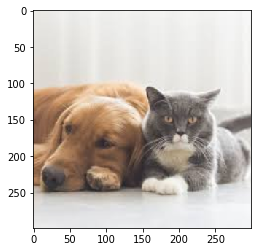

    Greedy Search: a black cat laying on top of a white couch
Beam Search (K=3): a black cat laying on top of a couch
Beam Search (K=5): a black cat sitting on top of a couch
Beam Search (K=7): a black cat sitting on top of a couch


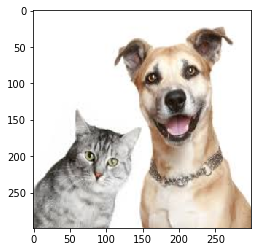

    Greedy Search: a cat is laying on the ground with a dog
Beam Search (K=3): a cat laying on top of a white car
Beam Search (K=5): there is a dog that is sleeping on the ground
Beam Search (K=7): there is a dog that is sleeping on the ground


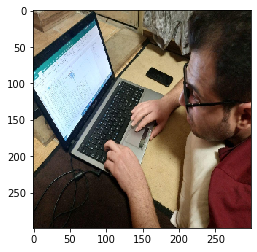

    Greedy Search: a man is sitting on a laptop computer
Beam Search (K=3): a man sitting on a laptop using a laptop computer
Beam Search (K=5): a man sitting on a laptop computer on a laptop
Beam Search (K=7): a close up of a person sitting on a laptop computer


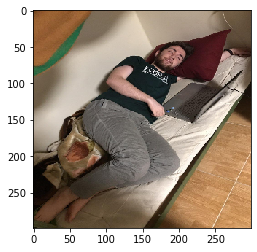

    Greedy Search: a person laying on a bed with a bottle of water
Beam Search (K=3): a person laying on a bed next to a laptop
Beam Search (K=5): a person sitting on top of a bed next to a laptop
Beam Search (K=7): a person sitting on top of a bed next to a laptop


In [8]:
image_name = ['index.jfif', 'fd.jfif', 'dogcat2.jfif', 'dogcat3.jfif', 'arash.jpg', 'r.jpg']
for name in image_name:
  img = cv2.resize( cv2.imread( '/gdrive/My Drive/Final Project/Test images/' + name ), (299, 299) )
  plt.imshow( img[:, :, ::-1] )
  plt.show()
  img = inception_resnet_v2.preprocess_input( np.expand_dims( img , axis=0 ) )
  print( '    Greedy Search: ' + greedySearch( model_fe.predict( img  ) ) )
  print( 'Beam Search (K=3): ' + beam_search_predictions( model_fe.predict( img  ) ) )
  print( 'Beam Search (K=5): ' + beam_search_predictions( model_fe.predict( img  ), 5 ) )
  print( 'Beam Search (K=7): ' + beam_search_predictions( model_fe.predict( img  ), 7 ) )